<a href="https://colab.research.google.com/github/ispapadakis/cifar10/blob/master/cifar10_COVNET_no_noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10 Analysis - No Noise

---

- Architecture: Sequential ConvNet
- Data Augmentation: Horizontal Flip, Rotate, Shift, Zoom


# Load Data and Libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers

Using TensorFlow backend.


In [0]:
from keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

170500096/170498071 [==============================] - 38s 0us/step


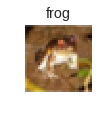

In [0]:
plt.figure(figsize=(1.2,1.5))
plt.imshow(x_train[0].astype('uint8'))
plt.suptitle(class_names[y_train[0][0]])
plt.axis('off')
plt.show()

In [0]:
# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [0]:
# Subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# If subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


In [0]:
num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

# Model Architecture

In [0]:
# Use Code from file, e.g.:
# !python3 "/content/drive/My Drive/app/mnist_cnn.py"

In [0]:
def covnet(baseMapNum = 64, weight_decay = 1e-4):
  keras.backend.clear_session()
  model = Sequential()
  model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(2*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Conv2D(4*baseMapNum, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.45))

  model.add(Flatten())
  model.add(Dense(num_classes, activation='softmax'))

  model.summary()
  
  return model

model = covnet()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_2

# Data Augmentation

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zoom_range=[0.8,1.4],
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )
datagen.fit(x_train)

# Training

In [0]:
def update_history(h,h_new):
    for k in h:
        h[k] += h_new[k]
    return h

In [0]:
batch_size = 64
optz = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
#optz = keras.optimizers.adam()
model.compile(loss='categorical_crossentropy', optimizer=optz, metrics=['accuracy'])
hist = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=2*x_train.shape[0] // batch_size, epochs=30, verbose=2, validation_data=(x_test,y_test))
model.save_weights('cifar10_ep{}.h5'.format(len(hist.history['loss'])))

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 - 89s - loss: 1.8711 - acc: 0.4714 - val_loss: 1.4358 - val_acc: 0.6057
Epoch 2/30
 - 84s - loss: 1.4510 - acc: 0.6185 - val_loss: 1.0558 - val_acc: 0.7212
Epoch 3/30
 - 84s - loss: 1.3463 - acc: 0.6688 - val_loss: 1.1348 - val_acc: 0.7371
Epoch 4/30
 - 85s - loss: 1.3073 - acc: 0.6984 - val_loss: 0.9399 - val_acc: 0.7853
Epoch 5/30
 - 84s - loss: 1.2733 - acc: 0.7160 - val_loss: 0.8925 - val_acc: 0.7914
Epoch 6/30
 - 84s - loss: 1.2519 - acc: 0.7342 - val_loss: 0.9384 - val_acc: 0.7850
Epoch 7/30
 - 85s - loss: 1.3018 - acc: 0.7327 - val_loss: 1.5402 - val_acc: 0.7589
Epoch 8/30
 - 84s - loss: 1.2561 - acc: 0.7436 - val_loss: 1.0063 - val_acc: 0.7921
Epoch 9/30
 - 84s - loss: 1.1910 - acc: 0.7549 - val_loss: 0.9273 - val_acc: 0.8071
Epoch 10/30
 - 84s - loss: 1.1923 - acc: 0.7625 - val_loss: 0.8984 - val_acc: 0.8135
Epoch 11/30
 - 84s - loss: 1.1337 - acc: 0.7701 - val_loss: 0.8422 - val_acc: 0.8354
Epoch 12/30
 - 84s - loss:

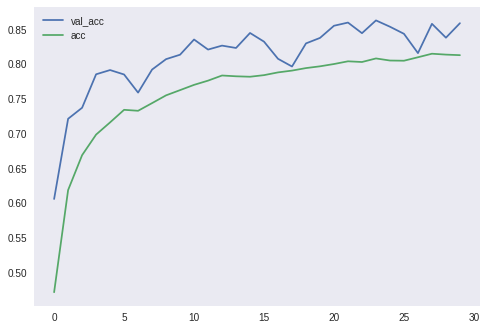

In [0]:
plt.plot(hist.history['val_acc'],label='val_acc')
plt.plot(hist.history['acc'],label='acc')
plt.legend()
plt.grid()
plt.show()

In [0]:
optz = keras.optimizers.rmsprop(lr=0.0007,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optz, metrics=['accuracy'])
hist2 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                            steps_per_epoch=2*x_train.shape[0] // batch_size,epochs=30,verbose=0,validation_data=(x_test,y_test))
hist.history = update_history(hist.history,hist2.history)
model.save_weights('cifar10_ep{}.h5'.format(len(hist.history['loss'])))

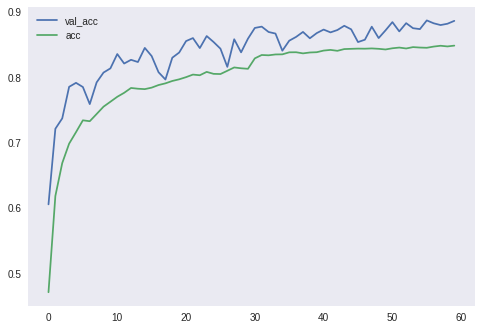

In [0]:
plt.plot(hist.history['val_acc'],label='val_acc')
plt.plot(hist.history['acc'],label='acc')
plt.legend()
plt.grid()
plt.show()

In [0]:
# checkpoint
checkpoint = keras.callbacks.ModelCheckpoint("cifar10_best.h5", monitor='val_acc', verbose=1, 
    save_best_only=True, mode='max')

#optz = keras.optimizers.rmsprop(lr=0.0003,decay=1e-6)
optz = keras.optimizers.adam(lr=0.00004)
model.compile(loss='categorical_crossentropy', optimizer=optz, metrics=['accuracy'])
hist2 = model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                            steps_per_epoch=2*x_train.shape[0] // batch_size,epochs=100,verbose=0,validation_data=(x_test,y_test),
                            callbacks=[checkpoint])

hist.history = update_history(hist.history,hist2.history)
pickle.dump( hist.history, open( "history.pkl", "wb" ) )


Epoch 00001: val_acc improved from -inf to 0.89740, saving model to cifar10_best.h5

Epoch 00002: val_acc improved from 0.89740 to 0.90120, saving model to cifar10_best.h5

Epoch 00003: val_acc did not improve from 0.90120

Epoch 00004: val_acc improved from 0.90120 to 0.90240, saving model to cifar10_best.h5

Epoch 00005: val_acc improved from 0.90240 to 0.90350, saving model to cifar10_best.h5

Epoch 00006: val_acc did not improve from 0.90350

Epoch 00007: val_acc did not improve from 0.90350

Epoch 00008: val_acc improved from 0.90350 to 0.90660, saving model to cifar10_best.h5

Epoch 00009: val_acc improved from 0.90660 to 0.90830, saving model to cifar10_best.h5

Epoch 00010: val_acc did not improve from 0.90830

Epoch 00011: val_acc improved from 0.90830 to 0.90870, saving model to cifar10_best.h5

Epoch 00012: val_acc did not improve from 0.90870

Epoch 00013: val_acc did not improve from 0.90870

Epoch 00014: val_acc did not improve from 0.90870

Epoch 00015: val_acc did not 

# Model Evaluation

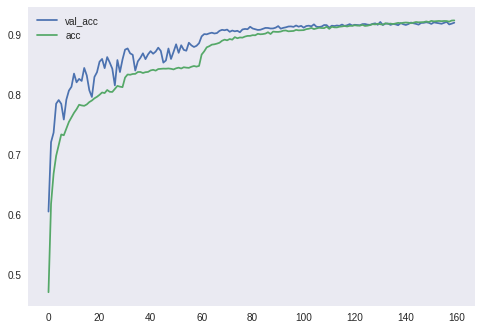

In [0]:
plt.plot(hist.history['val_acc'],label='val_acc')
plt.plot(hist.history['acc'],label='acc')
plt.legend()
plt.grid()
plt.show()

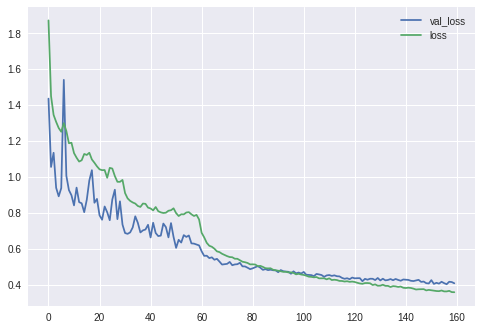

In [0]:
plt.plot(hist.history['val_loss'],label='val_loss')
plt.plot(hist.history['loss'],label='loss')
plt.legend()
plt.show()

In [0]:
model.load_weights("cifar10_best.h5")

In [0]:
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=2)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))


Test result: 92.160 loss: 0.404


In [0]:
# save as JSON
pickle.dump( model.to_json(), open( "model_json.pkl", "wb" ) )

In [0]:
prob_mat = model.predict(x_test)

In [0]:
prob_max = pd.Series(prob_mat.max(axis=1))
tbl = pd.crosstab(np.argmax(y_test,axis=1),np.argmax(prob_mat,axis=1))
tbl.index = pd.Index(class_names)
tbl.columns = ['pred_'+n for n in class_names]
tbl['total'] = tbl.sum(axis=1)
#tbl.loc['TOTAL',:] = tbl.sum(axis=0)
tbl.astype('int').style.background_gradient(high=1.)

,pred_airplane,pred_automobile,pred_bird,pred_cat,pred_deer,pred_dog,pred_frog,pred_horse,pred_ship,pred_truck,total
airplane,921,7,7,6,3,0,5,4,26,21,1000
automobile,0,973,0,0,0,0,0,0,6,21,1000
bird,17,2,891,9,20,15,33,8,2,3,1000
cat,8,4,23,809,24,52,49,10,5,16,1000
deer,2,0,13,10,933,8,26,7,1,0,1000
dog,4,3,20,74,21,844,13,13,1,7,1000
frog,2,3,9,6,2,1,974,1,1,1,1000
horse,4,1,7,8,16,5,4,950,1,4,1000
ship,13,6,2,1,0,0,1,1,964,12,1000
truck,5,29,0,1,2,0,1,0,5,957,1000


In [0]:
colSums = tbl.sum(0)
colSums.to_frame("TOTAL").transpose()

,pred_airplane,pred_automobile,pred_bird,pred_cat,pred_deer,pred_dog,pred_frog,pred_horse,pred_ship,pred_truck,total
TOTAL,976,1028,972,924,1021,925,1106,994,1012,1042,10000


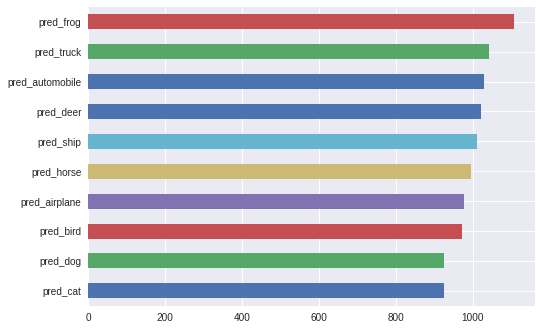

In [0]:
ax = colSums.iloc[:-1].sort_values().plot.barh()

In [0]:
tbl.astype('int')

,pred_airplane,pred_automobile,pred_bird,pred_cat,pred_deer,pred_dog,pred_frog,pred_horse,pred_ship,pred_truck,total
airplane,921,7,7,6,3,0,5,4,26,21,1000
automobile,0,973,0,0,0,0,0,0,6,21,1000
bird,17,2,891,9,20,15,33,8,2,3,1000
cat,8,4,23,809,24,52,49,10,5,16,1000
deer,2,0,13,10,933,8,26,7,1,0,1000
dog,4,3,20,74,21,844,13,13,1,7,1000
frog,2,3,9,6,2,1,974,1,1,1,1000
horse,4,1,7,8,16,5,4,950,1,4,1000
ship,13,6,2,1,0,0,1,1,964,12,1000
truck,5,29,0,1,2,0,1,0,5,957,1000


count    2466.000000
mean        0.812720
std         0.173069
min         0.284493
25%         0.691749
50%         0.878671
75%         0.961871
max         0.989973
dtype: float64
[('bird', 0.19932877), ('deer', 0.26278907), ('dog', 0.30012804), ('frog', 0.12841798)] dog 0.30012804


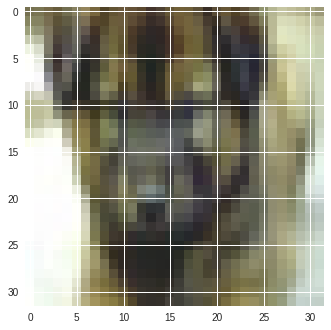

[('bird', 0.23219839), ('dog', 0.3271725), ('frog', 0.34914064)] bird 0.23219839


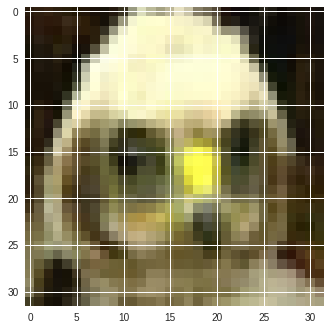

[('airplane', 0.19488877), ('bird', 0.29307485), ('truck', 0.3090243)] cat 0.0365147


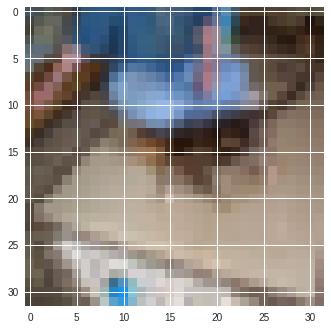

[('cat', 0.16302533), ('deer', 0.20653723), ('dog', 0.13932838), ('frog', 0.31925446)] dog 0.13932838


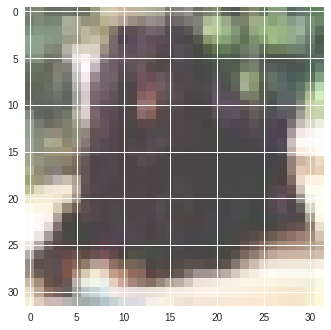

[('cat', 0.13167812), ('deer', 0.17066966), ('dog', 0.33137247), ('frog', 0.21928339)] dog 0.33137247


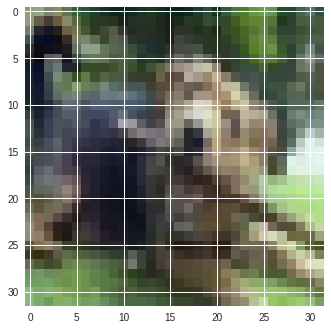

[('cat', 0.27971917), ('dog', 0.30816463), ('frog', 0.24470499)] cat 0.27971917


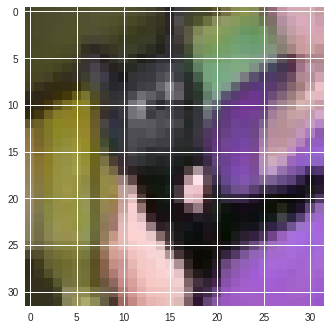

[('airplane', 0.30349636), ('automobile', 0.14282903), ('ship', 0.15597822), ('truck', 0.33111516)] automobile 0.14282903


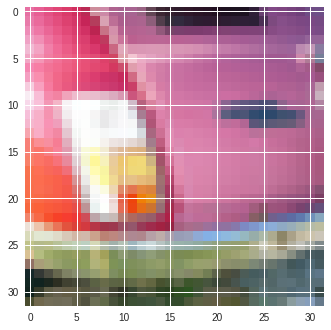

[('automobile', 0.17783844), ('dog', 0.30651543), ('horse', 0.16084999), ('truck', 0.33596703)] dog 0.30651543


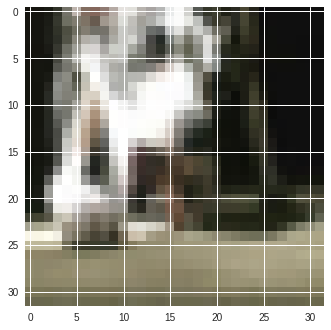

[('bird', 0.31729877), ('cat', 0.31426677), ('deer', 0.17736019)] bird 0.31729877


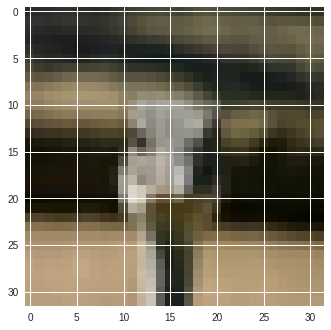

[('automobile', 0.11225117), ('cat', 0.17072797), ('dog', 0.34347743), ('frog', 0.34751433)] dog 0.34347743


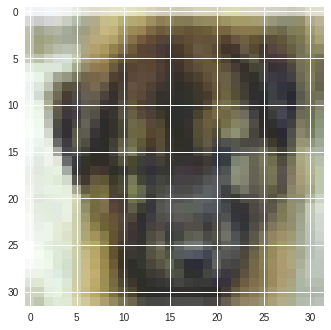

In [0]:
ylab = np.argmax(y_test,axis=1)
print(prob_max.loc[prob_max < .99].describe())
for i in np.where(prob_max < 0.35)[0][:10]:
    x = x_test[i]
    print([(c,prob_mat[i,j]) for j,c in enumerate(class_names) if prob_mat[i,j] > 0.1],
          class_names[ylab[i]],prob_mat[i,ylab[i]])
    plt.imshow((255.*(x + x_train_mean)).astype('uint8'))
    plt.show()